## LAB 4


Импорты!

In [33]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Грузим датасет, определим колонки которые будет рассматривать, рассмотрим уникальные значения в датасете

In [34]:
df = pd.read_csv('data_bn.csv')

columns_to_keep = ['age', 'smoke', 'allergy', 'asthma']

df_sub = df[columns_to_keep].copy()

for col in columns_to_keep:
    print(f"{col}: {df_sub[col].unique()}")

df_sub.head()

age: ['adult' 'old' 'young']
smoke: ['yes' 'no']
allergy: ['yes' 'no']
asthma: ['yes' 'no']


,age,smoke,allergy,asthma
0,adult,yes,yes,yes
1,old,no,yes,yes
2,adult,no,no,yes
3,adult,no,yes,no
4,adult,no,no,no


Будем рассматривать здоровье. Предположим такую связь между признаками:
1) Age -> Smoke - Возраст влияет на факт курения (молодые люди курят реже взрослых)
2) Smoke -> Asthma - Курение как фактор риска для астмы
3) Allergy -> Asthma - Аллергия повышает вероятность астмы

Asthma - целевая переменная. Age и Allergy считаем условно независимыми

Отрисуем граф

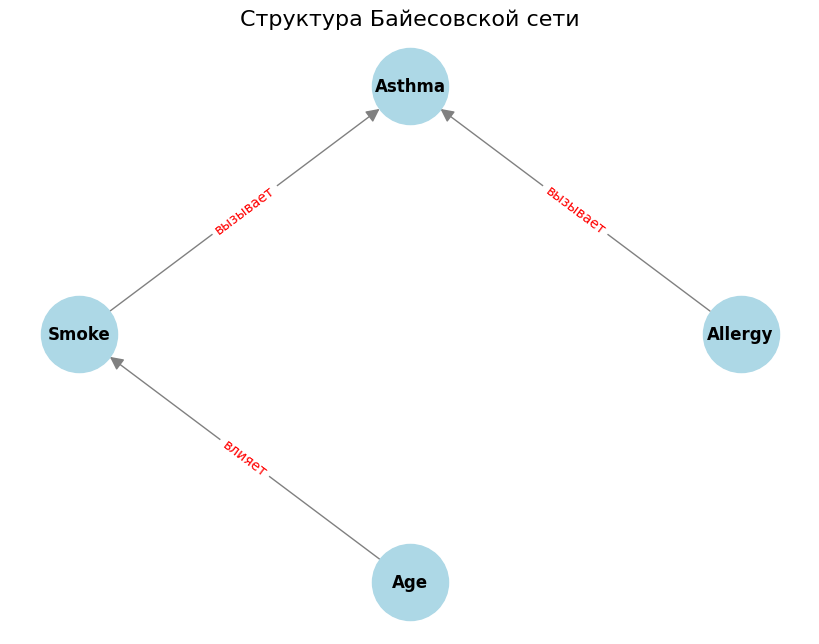

In [35]:
G = nx.DiGraph()

nodes = ['Age', 'Smoke', 'Allergy', 'Asthma']
G.add_nodes_from(nodes)

edges = [
    ('Age', 'Smoke'),
    ('Smoke', 'Asthma'),
    ('Allergy', 'Asthma')
]

edge_labels = {
    ('Age', 'Smoke'): 'влияет',
    ('Smoke', 'Asthma'): 'вызывает',
    ('Allergy', 'Asthma'): 'вызывает'
}

G.add_edges_from(edges)

plt.figure(figsize=(8, 6))
pos = {
    'Age': (0, -1),
    'Allergy': (0.5, 0),
    'Smoke': (-0.5, 0),
    'Asthma': (0, 1)
}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', arrowsize=20, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.title("Структура Байесовской сети", fontsize=16)
plt.show()

Перейдём к CPT

In [36]:
def cpt(df, child, parents):
    if not parents:
        return df[child].value_counts(normalize=True).sort_index()
    
    counts = df.groupby(parents + [child]).size().unstack(fill_value=0)
    probs = counts.div(counts.sum(axis=1), axis=0)
    return probs


cpt_asthma = cpt(df_sub, 'asthma', ['smoke', 'allergy'])
print("CPT для Asthma P(Asthma | Smoke, Allergy):")
display(cpt_asthma)

print()

cpt_smoke = cpt(df_sub, 'smoke', ['age'])
print("CPT для Smoke P(Smoke | Age):")
display(cpt_smoke)

print()

prior_allergy = cpt(df_sub, 'allergy', [])
print("Априорное распределение для Allergy P(Allergy):\n", prior_allergy, sep='')

CPT для Asthma P(Asthma | Smoke, Allergy):


asthma               no       yes
smoke allergy                    
no    no       0.694543  0.305457
      yes      0.253543  0.746457
yes   no       0.685065  0.314935
      yes      0.238095  0.761905


CPT для Smoke P(Smoke | Age):


smoke,no,yes
age,,
adult,0.798859,0.201141
old,0.896054,0.103946
young,0.859873,0.140127



Априорное распределение для Allergy P(Allergy):
allergy
no     0.723775
yes    0.276225
Name: proportion, dtype: float64


Что, как, зачем:

1) cpt_asthma показывает, как комбинация smoke и allergy влияет на вероятность заболевания. Наличие обоих факторов даёт максимальную вероятность астмы, а их отсутствие даёт минимальную вероятность.
2) Для оценки использовался прямой подсчёт частот в данных (ММП), сглаживание не было использовано, т.к. объём данных достаточен и нулевых вероятностей в анализируемых комбинациях не возникло.

Перейдём к вероятностям:

In [37]:
prob_asthma_given_smoke = cpt(df_sub, 'asthma', ['smoke'])
print("\nВероятности Asthma при различных состояниях Smoke:")
display(prob_asthma_given_smoke)

p_astma_yes_smoke_yes_allergy_yes = cpt_asthma.loc[('yes', 'yes'), 'yes']
p_astma_yes_smoke_no_allergy_no = cpt_asthma.loc[('no', 'no'), 'yes']

print(f"\nP(Asthma=yes | Smoke=yes, Allergy=yes) = {p_astma_yes_smoke_yes_allergy_yes:.4f}")
print(f"P(Asthma=yes | Smoke=no, Allergy=no) = {p_astma_yes_smoke_no_allergy_no:.4f}")


Вероятности Asthma при различных состояниях Smoke:


asthma,no,yes
smoke,,
no,0.573891,0.426109
yes,0.555300,0.444700



P(Asthma=yes | Smoke=yes, Allergy=yes) = 0.7619
P(Asthma=yes | Smoke=no, Allergy=no) = 0.3055


Результат довольно чётко совпал с интуицией, но курение само по себе всё же слабо влияет на астму

## Вывод:
Сеть позволила подтвердить мед. интуицию:
1) Курение и аллергия действительно сильно влияют на вероятность астмы. Наличие этих факторов повышают вероятность заболевания до максимума (0.76), а отсутствие снижают до минимума (0.3).
2) В структуре сети Age и Allergy являются условно независимыми, т.к. не связаны ребром и не имеют общего родителя. Это позволяет сети оценивать их "вклад" в болезнь независимо друг от друга.